In [1]:
import requests as rq
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from itertools import chain
from pipeline import *

# Pulling data from the NRS API

This API is undocumented, so my use here is entirely reverse-engineered through liberal use of cURL and Firefox's Nightly devtools. I've cached years 2003-2020 to speed up requests and lessen load on their system, but request the last year fresh to ensure updated data. In the future, I might autocache on a monthly basis, but I find the more caching, the larger the threshold for hard-to-find bugs.

In [2]:
start_time = "2021-01-01 00:00:00"
# end_time = "2021-07-29 00:00:00"
params = {
    'DataSet': 'SGWL.Working@OW283',
    'StartTime': start_time,
    # 'EndTime': end_time,
    'ExportFormat': 'csv',
    'Compressed': 'false',
    'RoundData': 'False',
    # 'Unit': '306', # metres
    'Unit': '228', # feet
    'Timezone': '-7', 
}

token = rq.post(url = "https://aqrt.nrs.gov.bc.ca/Export/DataSetToken", params=params).json()["Token"]
params['Token'] = token
response = rq.get(url = "https://aqrt.nrs.gov.bc.ca/Export/DataSet", params=params)
reader = csv.reader(response.text.splitlines())

# Processing and filtering data

This uses lots of functions from `pipeline.py`. 
It first concatenates the cached and fresh data, then runs it through a series of transformations. 
First, we filter out invalid data (status code < 0), then remove Feb. 29th to avoid dealing with leap years, clip spikes lower than 11 metres, and parse everything from strings to datetimes, floats, and ints. 
Then, we split each year into its own list and bring them forward, masking them as 2021 dates. We then transpose the rows and columns of each year to prepare for graphing.

In [3]:
with open("data/dataset.csv") as data:
    parsed = filter(lambda x: x, map(lambda x: clean_and_process(x[0], x[1], x[3]), chain(csv.reader(data), reader)))
    split = year_splitter(parsed)
years = tuple(map(lambda x: np.transpose(unify_year(x)), split))

# Graphing

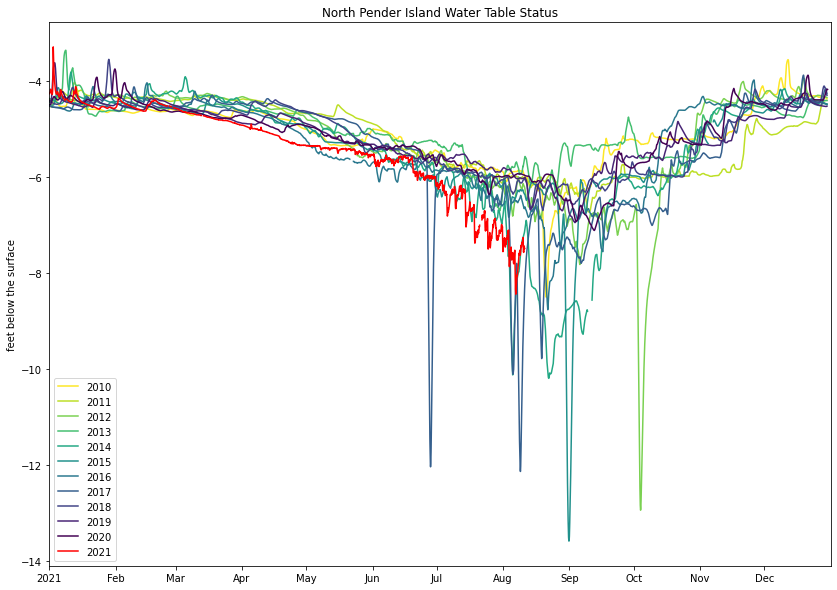

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

ax.set_ylabel("feet below the surface")
ax.set_title("North Pender Island Water Table Status")
ax.set_xlim(years[-1][0][0], years[0][0][-1])

# fancy automatic date labels along x axis
locator = mdates.AutoDateLocator(minticks=3, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# chosen for linear perception and contrast with red
colourmap = cm.get_cmap('viridis')

# graphing each year with its own label and colour along the viridis colourmap
year_plots = []
for i, year in enumerate(years[7:-1]):
    year_as_percentage = i/(2020-2010)
    (year_plot, ) = ax.plot(year[0][:-40], rolling_mean(year[1], 40)[:-40], color=colourmap(1-year_as_percentage), label=i+2010)
    year_plots.append(year_plot)

# current year
ax.plot(years[-1][0], years[-1][1], color="red", label=2021)

ax.legend()

fig.savefig("www/output.png")

# Notes

The natural level, with enough rainfall and non-overwhelming water use, seems to be ~-4.4m. 
Spikes lasting a day or two appear, presumably from heavy rainfall, but quickly return to the resting level.
Beginning in roughly April-May, increased water usage, increased temperature, and decreased summer rainfall cause a slow decline until around July, at which point droughts begin, and water level plummets rapidly in some years (including 2021!)
The dry season lasts until September, and the autumn rains replenish the aquifers for the new year.
I believe sharp spikes to be artifacts of faulty data collection or instrument errors, as the aquifer simply cannot fall and rise 10 metres in the same day.
A combination of outlier clipping and 24-hr rolling averaging helps to smooth out the worst spikes, but introduces its own artifacts.
Namely, the nearly-perfect right-angle dip on April 1st, which is nonexistent without the convolution and increases in amplitude with a longer window.
The data also has gaps, which my filtering has not yet managed to completely eliminate. 
The longer the window, the longer the gaps become, but they are present even in raw data.
They should be marked by a status code of -3, but this undocumented API isn't perfect.
I've removed data from before 2003 as it was being measured by an unknown method, so the precision, accuracy, and resolution are significantly worse than the automated, solar-satellite depth sensor installed today.

In [6]:
with open("index.html") as index:
    index = index.read().replace("XX", ("%2.1f" % years[-1][-1][-1])[1:], 1)
with open("www/index.html", "w") as new_index:
    new_index.write(index)
print(index)

<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Watertable</title>
    <link rel='stylesheet' href='style.css'>
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Lexend&display=swap');
        </style> 
</head>
<body>
    <h1>North Pender Island Water Table</h1>
    <div class="summary">
        <p class="left-col">The water level is currently</p>
        <p id="water-level" class="dyn-important">7.5</p>
        <p class="right-col">feet below the surface.</p>
        <p class="left-col">Ordinarily, in <span class="rough-time">this time of year</span>, it's about</p>
        <p id="historical-water-level" class="dyn-important">XX</p>
        <p class="right-col">feet below the surface.</p>
    </div>
    <div class="graph-wrapper">
        <img src="/output.png" alt="A graph showing the water level for this year, and 